In [226]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np

def parse_place_file(file_path: str):
    """
    Parses a VPR .place file and returns the data as a pandas DataFrame.
    
    Args:
        file_path (str): Path to the .place file.
    
    Returns:
        pd.DataFrame: A DataFrame containing the parsed data with columns:
                      ['block_name', 'x', 'y', 'sub_tile']
    """
    data = []
    header = []
    header_done = False
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line or not header_done or line.startswith('#'):
                # Store header lines or skip comments
                if line.startswith('#'):
                    header_done = True
                header.append(line)
                continue
            # Parse block entries
            parts = line.split()
            if len(parts) >= 3:
                block_name = parts[0]
                x = int(parts[1])
                y = int(parts[2])
                sub_tile = int(parts[3]) if len(parts) > 3 else None
                data.append((block_name, x, y, sub_tile))

    # Create a DataFrame for structured representation
    df = pd.DataFrame(data, columns=['block_name', 'x', 'y', 'sub_tile'])
    return df, header

def parse_toplevel_blocks(file_path: str):
    """
    Parses a VPR .net XML file and extracts the name and mode of top-level blocks.

    Args:
        file_path (str): Path to the .net file.

    Returns:
        dict: A dictionary where keys are block names and values are their modes.
    """
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract top-level blocks into a dictionary
    top_blocks = {}
    for block in root.findall("block"):
        name = block.get("name")
        mode = block.get("mode")
        if name:  # Only include blocks with a name
            top_blocks[name] = mode

    return top_blocks

def visualize_netlist_and_placement_with_colors(place_data, net_data, path_data):
    """
    Visualizes placement and netlist using networkx, with node colors based on instance types.
    
    Args:
        place_data (pd.DataFrame): Parsed .place data.
        net_data (dict): A dictionary where keys are block names and values are their modes.
    """
    G = nx.DiGraph()
    node_colors = []

    # Add nodes from place data
    for _, row in place_data.iterrows():
        block_name = row['block_name']
        # Assign node color based on block_name pattern
        if "red" in net_data[block_name] or "in" in net_data[block_name] or "out" in net_data[block_name]:
            node_color = 'red'
        else:
            node_color = 'lightblue'  # Default color for other nodes
        G.add_node(block_name, pos=(row['x'], row['y']), color=node_color)
        node_colors.append(node_color)

    # Add edges from net data
    # for net in net_data:
    #     connections = net['connections']
    #     for i in range(len(connections) - 1):
    #         block1, _ = connections[i]
    #         block2, _ = connections[i + 1]
    #         G.add_edge(block1, block2, net=net['net_name'])

    np.random.seed(42)
    n = 0
    for path in path_data:
        # random color for each path
        r, g, b = np.random.random(), np.random.random(), np.random.random()
        path_color = (r, g, b)
        for i in range(len(path) - 1):
            block1 = path[i]
            block2 = path[i + 1]
            if G.has_edge(block1, block2):
                edge = G.get_edge_data(block1, block2)
                # edge['net'] += ', ' + str(n)
                edge['net'] += 1
                # edge['color'] = path_color  # For now, do not update edge color
            else:
                # G.add_edge(block1, block2, net=str(n), color=path_color)
                G.add_edge(block1, block2, net=1, color=path_color)
        n += 1

    # Get positions and colors for nodes
    pos = nx.get_node_attributes(G, 'pos')
    node_colors = nx.get_node_attributes(G, 'color').values()
    edge_colors = [d['color'] for _, _, d in G.edges(data=True)]

    # Draw the graph
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color=list(node_colors), edge_color=edge_colors)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['net'] for u, v, d in G.edges(data=True)})
    plt.title("VPR Placement and Netlist Visualization with Node Colors")
    plt.show()

def calculate_hops(place_data, paths):
    """
    Calculate the pathlengths for a given placement and paths.

    Args:
        place_data (dataframe): As obtained from parse_place_file.
        paths (list of lists): As obtained from parse_paths_file

    Returns:
        hops (list of lists): list of hop lengths, sum of hop lengths
        sums (list): list of sums of hop lengths
        idx_maxpath (int): index of the longest path
    """
    hops = []
    sums = []
    for path in paths:
        hop = []
        for i, block in enumerate(path):
            if i >= len(path) - 1:
                break
            x1 = place_data.loc[place_data['block_name'] == block, 'x'].values[0]
            x2 = place_data.loc[place_data['block_name'] == path[i + 1], 'x'].values[0]
            y1 = place_data.loc[place_data['block_name'] == block, 'y'].values[0]
            y2 = place_data.loc[place_data['block_name'] == path[i + 1], 'y'].values[0]
            dist = abs(x1 - x2) + abs(y1 - y2)
            hop.append(dist)
        hops.append(hop)
        sums.append(sum(hop))

    idx_maxpath = sums.index(max(sums))

    return hops, sums, idx_maxpath

import numpy as np
import matplotlib.pyplot as plt

def plot_histogram_side_by_side(series_data, labels, colors=None, title=None, norm=None, minbins=None, integers=True, roundto=1, skipticks=1):
    """
    Plots a histogram with bins for multiple data series, positioning bars side-by-side
    and displaying ticks as floating-point values.

    Args:
        series_data (list of lists): A list containing data series (each series can contain floats or integers).
        labels (list of str): Labels for each data series (for the legend).
        colors (list of str): List of colors for the data series (optional).
        title (str): Title for the plot (optional).
        norm (float): Normalize the data by dividing through this number.
        minbins (int): Minimum number of bins (optional).
        integers (bool): If True, use integer bins and integer x-axis representation.
    """
    if norm is None:
        norm = 1
    if not colors:
        cmap = plt.colormaps['tab10']  # 'tab10' is a qualitative colormap with 10 distinct colors
        colors = [cmap(i % 10) for i in range(len(series_data))]

    # Determine range of bins
    min_value = min(min(series) for series in series_data)
    max_value = max(max(series) for series in series_data)

    # Define bin edges
    if minbins is not None:
        bin_edges = np.linspace(min_value, max(max_value, min_value + minbins), minbins + 1)
    else:
        bin_edges = np.histogram_bin_edges(np.concatenate(series_data), bins='auto')
    if integers:
        bin_edges = np.arange(int(np.floor(bin_edges[0])), int(np.ceil(bin_edges[-1])) + 1)

    # Calculate bin positions as integers
    positions = np.arange(len(bin_edges) - 1)  # Integer x-axis positions for bars
    tick_labels = bin_edges[:-1]  # Integer labels for ticks
    # tick_labels = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]  # Floating-point midpoints for ticks

    # Calculate bin positions and bar width
    bin_width = bin_edges[1] - bin_edges[0]  # Width of a single bin
    positions = np.arange(len(bin_edges) - 1)  # Integer x-axis positions for bins
    position_width = positions[1] - positions[0]

    bar_width = 0.8 / len(series_data)  # Split the bin width among series
    offsets = np.linspace(-0.4, 0.4, len(series_data), endpoint=False)

    # Plot bars for each data series
    bars = []
    counts = []
    counts_t = []
    for series, label, color, offset in zip(series_data, labels, colors, offsets):
        bin_counts, _ = np.histogram(series, bins=bin_edges)
        counts.append(bin_counts / norm)  # Normalized counts
        counts_t.append(bin_counts)
        b = plt.bar(
            positions + offset, counts[-1], width=bar_width, color=color,
            label=label, align='edge'
        )
        bars.append(b)

    # Add data annotations
    counts_printed = [0]
    for b in range(len(bars[0])):
        for i in range(len(bars)):
            bar = bars[i][b]
            count = counts_t[i][b]
            if not count in counts_printed:
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.002,
                    str(count),
                    ha='center', va='bottom', fontsize=9
                )
                counts_printed.append(count)


    # Add x-axis ticks with floating-point labels
    ax = plt.gca()
    # plt.xticks([positions[i] for i in range(0, len(positions), skipticks)], labels=[f"{round(tick_labels[i],roundto)}".rstrip('0').rstrip('.') for i in range(0, len(tick_labels), skipticks)])
    labels = [f"{round(tick, roundto)}".rstrip('0').rstrip('.') if i % skipticks == 0 else "" for i, tick in enumerate(tick_labels)]  # Show every 3rd tick
    plt.xticks(positions, labels)

    for edge in positions:
        plt.axvline(edge - position_width / 2, color='gray', linestyle='--', linewidth=0.5, zorder=0)
    plt.axvline(positions[-1] + position_width / 2, color='gray', linestyle='--', linewidth=0.5, zorder=0)

    # Labels, legend, and title
    plt.xlabel("Values")
    plt.ylabel("Occurrences")
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title("Histogram of Data")
    plt.show()
    return counts



def generate_label_for_hists(paths, hops_sums, idx):
    return f"Path has {len(paths[idx])} blocks, dist {hops_sums[idx]}"

def parse_timing_report(file_path):
    """
    Parses the first path from the timing report and removes duplicate occurrences
    of points (e.g., "xxx.in" and "xxx.out" reduced to "xxx").

    Args:
        file_path (str): Path to the timing report file.

    Returns:
        paths (list of lists): A list of all 'paths' each constructed by blocknames.
        cpds (list of floats): A list of the CPD value for each path.
    """
    paths = []
    cpds = []
    in_path = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            if line.startswith("slack (VIOLATED)"):
                cpd = float(line.split(" ")[-1])
                cpds.append(cpd)

            if not in_path:
                if line.startswith("#Path "):
                    path_points = []
                    go_looking = False
                    keep_lines = False
                    sp = None
                    ep = None
                    in_path = True
            else:
                # Parse points only if inside the first path
                if line.startswith("Startpoint:"):
                    sp = line.split(" ")[1]  # Extract the startpoint name
                elif line.startswith("Endpoint"):
                    ep = line.split(":")[1].split()[0]  # Extract the endpoint name
                    go_looking = True
                elif go_looking:
                    if line.startswith(sp) or keep_lines:
                        keep_lines = True
                        point = line.split()[0]  # Extract the first column (the point name)
                        stripped_point = point.split('.')[0]  # Strip ".in" or ".out"
                        if stripped_point not in path_points:
                            path_points.append(stripped_point)
                    if line.startswith(ep):
                        in_path = False
                        paths.append(path_points)

    return paths, cpds

def read_paths_file(file_path):
    """
    Reads a paths file and returns the paths as a list of lists of strings.

    Args:
        file_path (str): Path to the .paths file.

    Returns:
        list of lists of str: A list of paths, each path being a list of block names.
    """
    paths = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            path = line.split()
            paths.append(path)
    return paths

def find_path_in_paths(path, paths):
    """
    Searches a list of lists of paths (strings) for the occurrence of one path (list of strings).

    Args:
        path (list of str): The path to search for.
        paths (list of lists of str): The list of paths to search in.

    Returns:
        bool: True if the path is found, False otherwise.
        int: The index of the path in the list, or None if not found.
    """
    for p in paths:
        if len(path) == len(p):
            equal = True
            for b1, b2 in zip(path, p):
                if b1 != b2:
                    equal = False
                    break
            if equal:
                idx = paths.index(path)
                return True, idx
    return False, None

In [83]:
def read_all_data(data, path_prefix, circuit):
    entry = path_prefix + circuit
    # Context
    data[entry] = {}

    # Obtain mode of blocks (simplified)
    data[entry]['blocks'] = parse_toplevel_blocks(path_prefix + circuit + ".net")

    # Obtain location of blocks
    data[entry]['df_markus'], _     = parse_place_file(path_prefix + "initial.place")
    data[entry]['df_final'], _ = parse_place_file(path_prefix + circuit + ".place")

    # Read timing information, obtain paths and CPDs
    paths_initial, data[entry]['cpds_initial'] = parse_timing_report(path_prefix + "pre_pack.report_timing.setup.rpt")
    paths_markus, data[entry]['cpds_markus'] = parse_timing_report(path_prefix + "markus_timing_report.rpt")
    paths_final, data[entry]['cpds_final'] = parse_timing_report(path_prefix + "timing_post_place.rpt")
    paths = set()
    for p in paths_initial:
        paths.add(tuple(p))
    for p in paths_markus:
        paths.add(tuple(p))
    for p in paths_final:
        paths.add(tuple(p))
    print(f"Found {len(paths)} unique paths in total")
    path_initial = paths_initial[0]
    path_markus = paths_markus[0]
    path_final = paths_final[0]
    if 'stroobandt' in path_prefix:
        paths_stroobandt = read_paths_file(path_prefix + "paths.txt")
        indices = [i for i, x in enumerate(paths_stroobandt) if x == max(paths_stroobandt, key=len)]
        for i in indices:
            paths.add(tuple(paths_stroobandt[i]))

    data[entry]['paths'] = [list(p) for p in paths]
    f, data[entry]['idx_path_initial'] = find_path_in_paths(path_initial, data[entry]['paths'])
    f, data[entry]['idx_path_markus'] = find_path_in_paths(path_markus, data[entry]['paths'])
    f, data[entry]['idx_path_final'] = find_path_in_paths(path_final, data[entry]['paths'])
    if 'stroobandt' in path_prefix:
        lens = [len(path) for path in paths_stroobandt]
        f, data[entry]['idx_path_stroobandt'] = find_path_in_paths(paths_stroobandt[lens.index(max(lens))],data[entry]['paths'])
    else:
        data[entry]['idx_path_stroobandt'] = None

    data[entry]['lens'] = [len(path) for path in paths]
    # print(f"Path lengths: {lens}")
    data[entry]['max_len'] = max(data[entry]['lens'])
    print(f"Path of maximum length: {data[entry]['max_len']} blocks i.e. {data[entry]['max_len'] - 1} hops")

    data[entry]['hops_markus'], data[entry]['sums_markus'], data[entry]['idx_maxhops_markus'] = calculate_hops(data[entry]['df_markus'], data[entry]['paths'])
    print("Initial placement:")
    if data[entry]['paths'][data[entry]['idx_maxhops_markus']] == paths_markus[0]:
        print("\tthe physically longest path has the highest delay")
        print(f"\thas a maximum distance of {data[entry]['sums_markus'][data[entry]['idx_maxhops_markus']]} in {len(data[entry]['hops_markus'][data[entry]['idx_maxhops_markus']])} hops taking {data[entry]['cpds_markus'][0]}ns")
    else:
        print("\tthe physically longest path does NOT have the highest delay")
        print(f"\thas a maximum distance of {data[entry]['sums_markus'][data[entry]['idx_maxhops_markus']]} in {len(data[entry]['hops_markus'][data[entry]['idx_maxhops_markus']])} hops")
        f, idx = find_path_in_paths(paths_markus[0], data[entry]['paths'])
        print(f"\thas a worst CPD of {data[entry]['cpds_markus'][0]}ns (distance {data[entry]['sums_markus'][idx]}, {len(paths_markus[0]) - 1} hops)")

    data[entry]['hops_final'], data[entry]['sums_final'], data[entry]['idx_maxhops_final'] = calculate_hops(data[entry]['df_final'], data[entry]['paths'])
    print("Final placement:")
    if data[entry]['paths'][data[entry]['idx_maxhops_final']] == paths_final[0]:
        print("\tthe physically longest path has the highest delay")
        print(f"\thas a maximum distance of {data[entry]['sums_final'][data[entry]['idx_maxhops_final']]} in {len(data[entry]['hops_final'][data[entry]['idx_maxhops_final']])} hops taking {data[entry]['cpds_final'][0]}ns")
    else:
        print("\tthe physically longest path does NOT have the highest delay")
        print(f"\thas a maximum distance of {data[entry]['sums_final'][data[entry]['idx_maxhops_final']]} in {len(data[entry]['hops_final'][data[entry]['idx_maxhops_final']])} hops")
        print(f"\tplacement has a worst CPD of {data[entry]['cpds_final'][0]}ns (distance {data[entry]['sums_final'][data[entry]['idx_path_final']]}, {len(paths_final[0]) - 1} hops)")

In [7]:
data = {}

In [ ]:
circuit     = "2000"
path_prefix = "temp/vprs/original_2000_raveena_1/"
read_all_data(data, path_prefix, circuit)

In [ ]:
# Get all locations of the file
root_dir = 'temp/vprs/'
for dirpath, _, filenames in os.walk(root_dir):
    if 'vpr_stdout.log' in filenames:
        path_prefix = dirpath + '/'
        circuit = dirpath.split('/')[-1].split('_')[1]
        print(path_prefix)
        print(circuit)
        read_all_data(data, path_prefix, circuit)


In [ ]:
visualize_netlist_and_placement_with_colors(data[entry]['df_final'], data[entry]['blocks'], data[entry]['paths'])

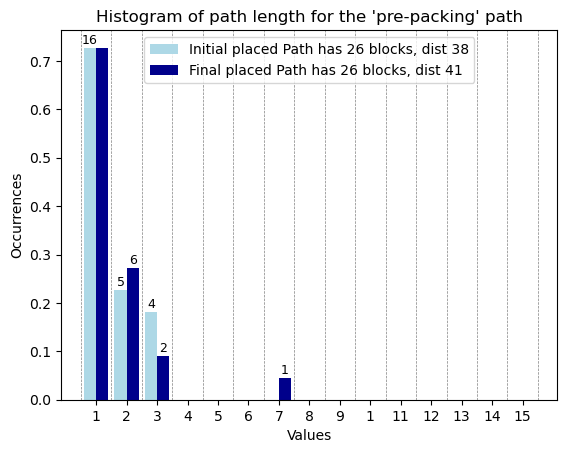

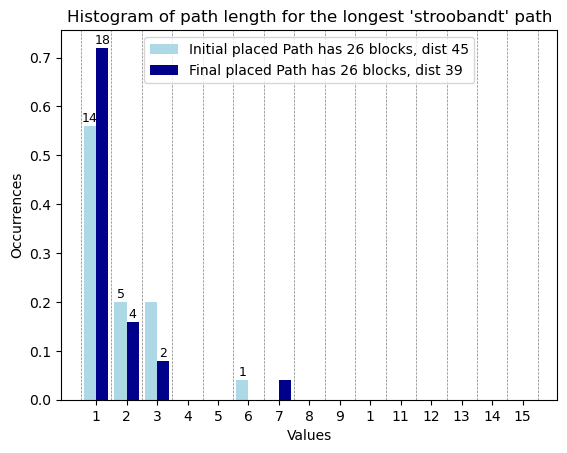

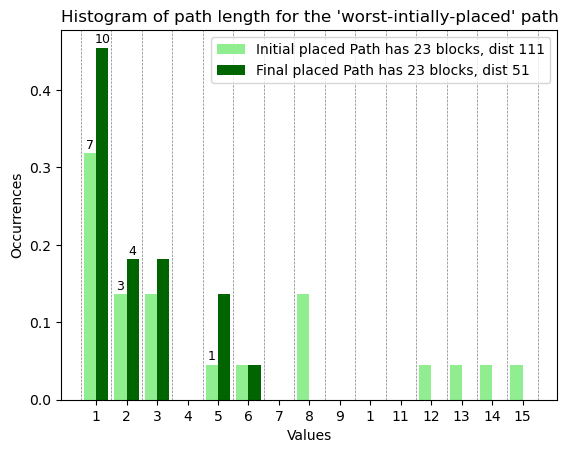

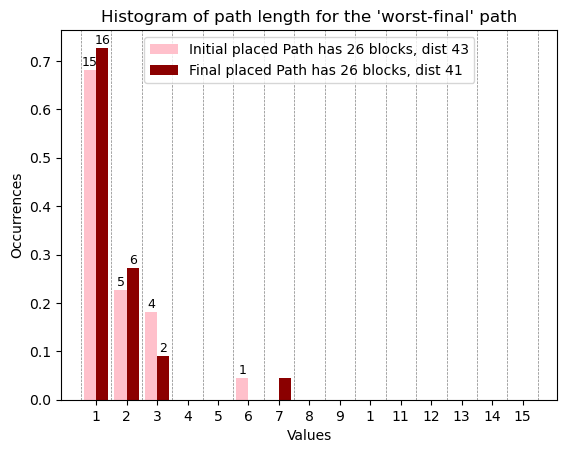

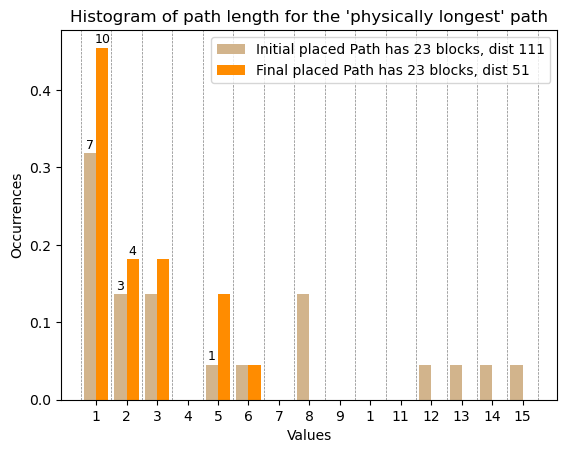

In [239]:
# Generate histograms for path distance distribution after initial placement and final placement
circuit     = "100"
it = 3
path_prefix = f"temp/vprs/stroobandt_{circuit}_raveena_{it}/"
entry = path_prefix + circuit
minbins = 15

colors = ['lightblue', 'darkblue']
labels = [f"Initial placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_markus'], data[entry]['idx_path_initial'])}", f"Final placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_final'], data[entry]['idx_path_initial'])}"]
counts = plot_histogram_side_by_side([data[entry]['hops_markus'][data[entry]['idx_path_initial']], data[entry]['hops_final'][data[entry]['idx_path_initial']]], labels, title="Histogram of path length for the 'pre-packing' path", colors=colors, norm=len(data[entry]['hops_final'][data[entry]['idx_path_markus']]), minbins=minbins)

if data[entry]['idx_path_stroobandt']:
    labels = [f"Initial placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_markus'], data[entry]['idx_path_stroobandt'])}", f"Final placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_final'], data[entry]['idx_path_stroobandt'])}"]
    counts = plot_histogram_side_by_side([data[entry]['hops_markus'][data[entry]['idx_path_stroobandt']], data[entry]['hops_final'][data[entry]['idx_path_stroobandt']]], labels, title="Histogram of path length for the longest 'stroobandt' path", colors=colors, norm=len(data[entry]['hops_final'][data[entry]['idx_path_stroobandt']]), minbins=minbins)

colors = ['lightgreen', 'darkgreen']
labels = [f"Initial placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_markus'], data[entry]['idx_path_markus'])}", f"Final placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_final'], data[entry]['idx_path_markus'])}"]
counts = plot_histogram_side_by_side([data[entry]['hops_markus'][data[entry]['idx_path_markus']], data[entry]['hops_final'][data[entry]['idx_path_markus']]], labels, title="Histogram of path length for the 'worst-intially-placed' path", colors=colors, norm=len(data[entry]['hops_final'][data[entry]['idx_path_markus']]), minbins=minbins)

colors = ['pink', 'darkred']
labels = [f"Initial placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_markus'], data[entry]['idx_path_final'])}", f"Final placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_final'], data[entry]['idx_path_final'])}"]
counts = plot_histogram_side_by_side([data[entry]['hops_markus'][data[entry]['idx_path_final']], data[entry]['hops_final'][data[entry]['idx_path_final']]], labels, title="Histogram of path length for the 'worst-final' path", colors=colors, norm=len(data[entry]['hops_final'][data[entry]['idx_path_markus']]), minbins=minbins)

if data[entry]['idx_maxhops_final'] != data[entry]['idx_path_final']:
    colors = ['tan', 'darkorange']
    labels = [f"Initial placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_markus'], data[entry]['idx_maxhops_final'])}", f"Final placed {generate_label_for_hists(data[entry]['paths'], data[entry]['sums_final'], data[entry]['idx_maxhops_final'])}"]
    counts = plot_histogram_side_by_side([data[entry]['hops_markus'][data[entry]['idx_maxhops_final']], data[entry]['hops_final'][data[entry]['idx_maxhops_final']]], labels, title="Histogram of path length for the 'physically longest' path", colors=colors, norm=len(data[entry]['hops_final'][data[entry]['idx_maxhops_final']]), minbins=minbins)



For original we look at 48 circuits
For stroobandt we look at 48 circuits


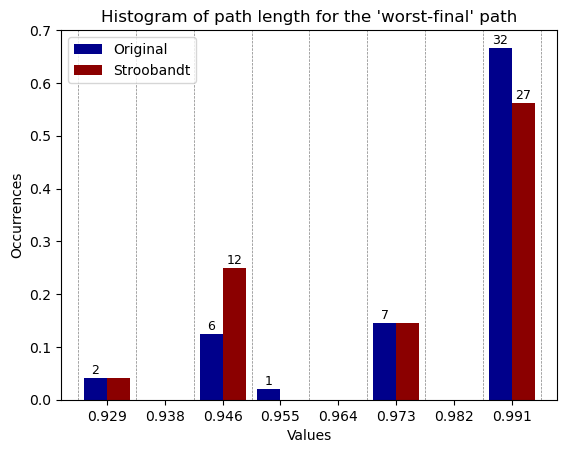

In [206]:
# For all circuits worst paths calculate in hops: length of final path / length of initial path
# (should be < 1)
d1 = []
d2 = []
for filter, d in zip(['original', 'stroobandt'], [d1, d2]):
    for entry in data.keys():
        if filter not in entry:
            continue
        prop = len(data[entry]['paths'][data[entry]['idx_path_final']]) / len(data[entry]['paths'][data[entry]['idx_path_initial']])
        d.append(prop)
    print(f"For {filter} we look at {len(d)} circuits")

colors = ['darkblue', 'darkred']
labels = ['Original', 'Stroobandt']
counts = plot_histogram_side_by_side([d1, d2], labels, title="Histogram of path length for the 'worst-final' path", colors=colors, integers=False, roundto=3, norm=len(d1))


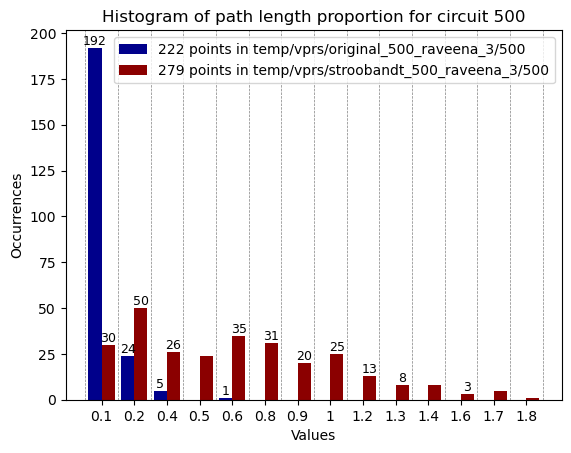

[array([192.,  24.,   5.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.]),
 array([30., 50., 26., 24., 35., 31., 20., 25., 13.,  8.,  8.,  3.,  5.,
         1.])]

In [228]:
# For one circuit all paths calculate in distance: length of final path / length of initial path
circuit     = "500"
it = 3
e1 = f"temp/vprs/original_{circuit}_raveena_{it}/{circuit}"
e2 = f"temp/vprs/stroobandt_{circuit}_raveena_{it}/{circuit}"
labels = [f"{len(data[e1]['sums_markus'])} points in {e1}", f"{len(data[e2]['sums_markus'])} points in {e2}"]
colors = ['darkblue', 'darkred']
d1 = [df/di for di, df in zip(data[e1]['sums_markus'], data[e1]['sums_final'])]
d2 = [df/di for di, df in zip(data[e2]['sums_markus'], data[e2]['sums_final'])]
plot_histogram_side_by_side([d1, d2], labels, colors=colors, title=f"Histogram of path length proportion for circuit {circuit}", integers=False)


For original we look at 48 circuits
For stroobandt we look at 48 circuits


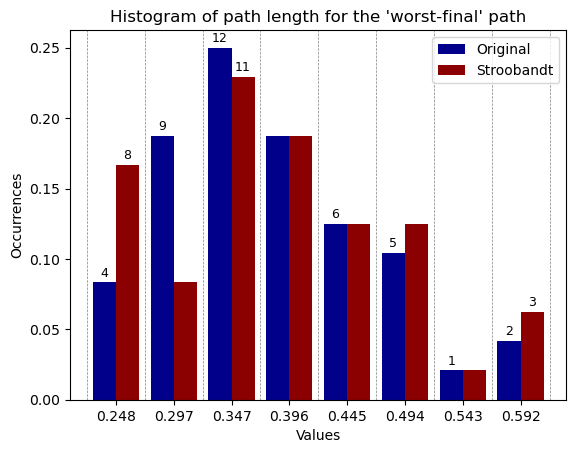

In [ ]:
# For all circuits worst paths calculate in hops: hops of final path / distance of final path
# (should be < 1)
d1 = []
d2 = []
for filter, d in zip(['original', 'stroobandt'], [d1, d2]):
    for entry in data.keys():
        if filter not in entry:
            continue
        prop = len(data[entry]['hops_final'][data[entry]['idx_path_final']]) / data[entry]['sums_final'][data[entry]['idx_path_final']]
        d.append(prop)
    print(f"For {filter} we look at {len(d)} circuits")

colors = ['darkblue', 'darkred']
labels = ['Original', 'Stroobandt']
counts = plot_histogram_side_by_side([d1, d2], labels, title="Histogram of path length for the 'worst-final' path", colors=colors, integers=False, roundto=3, norm=len(d1))

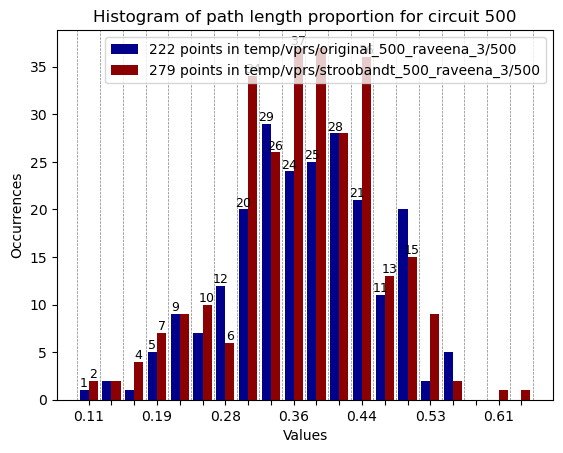

[array([ 1.,  2.,  1.,  5.,  9.,  7., 12., 20., 29., 24., 25., 28., 21.,
        11., 20.,  2.,  5.,  0.,  0.,  0.]),
 array([ 2.,  2.,  4.,  7.,  9., 10.,  6., 34., 26., 37., 37., 28., 36.,
        13., 15.,  9.,  2.,  0.,  1.,  1.])]

In [231]:
# For one circuits all paths calculate in hops: hops of path / distance of path
# (should be < 1)
circuit     = "500"
it = 3
e1 = f"temp/vprs/original_{circuit}_raveena_{it}/{circuit}"
e2 = f"temp/vprs/stroobandt_{circuit}_raveena_{it}/{circuit}"
labels = [f"{len(data[e1]['hops_final'])} points in {e1}", f"{len(data[e2]['hops_final'])} points in {e2}"]
colors = ['darkblue', 'darkred']
d1 = [len(hops) / dist for hops, dist in zip(data[e1]['hops_final'], data[e1]['sums_final'])]
d2 = [len(hops) / dist for hops, dist in zip(data[e2]['hops_final'], data[e2]['sums_final'])]
plot_histogram_side_by_side([d1, d2], labels, colors=colors, title=f"Histogram of path length proportion for circuit {circuit}", integers=False, roundto=2, skipticks=3)
